In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'silu',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

silu_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/80 [..............................] - ETA: 2:03 - loss: 0.0941 - STD: 0.0059 - MAE: 0.2924

 4/80 [>.............................] - ETA: 2s - loss: 0.0372 - STD: 0.0151 - MAE: 0.1531  

 5/80 [>.............................] - ETA: 2s - loss: 0.0323 - STD: 0.0158 - MAE: 0.1422

 6/80 [=>............................] - ETA: 2s - loss: 0.0285 - STD: 0.0168 - MAE: 0.1305

 7/80 [=>............................] - ETA: 3s - loss: 0.0262 - STD: 0.0174 - MAE: 0.1232

 8/80 [==>...........................] - ETA: 3s - loss: 0.0241 - STD: 0.0178 - MAE: 0.1167

 9/80 [==>...........................] - ETA: 3s - loss: 0.0224 - STD: 0.0181 - MAE: 0.1123

10/80 [==>...........................] - ETA: 3s - loss: 0.0212 - STD: 0.0182 - MAE: 0.1099

11/80 [===>..........................] - ETA: 3s - loss: 0.0201 - STD: 0.0186 - MAE: 0.1070

12/80 [===>..........................] - ETA: 3s - loss: 0.0191 - STD: 0.0191 - MAE: 0.1038

13/80 [===>..........................] - ETA: 3s - loss: 0.0184 - STD: 0.0195 - MAE: 0.1013

14/80 [====>.........................] - ETA: 3s - loss: 0.0177 - STD: 0.0200 - MAE: 0.0990

15/80 [====>.........................] - ETA: 3s - loss: 0.0170 - STD: 0.0205 - MAE: 0.0970

16/80 [=====>........................] - ETA: 3s - loss: 0.0165 - STD: 0.0209 - MAE: 0.0957

17/80 [=====>........................] - ETA: 3s - loss: 0.0160 - STD: 0.0215 - MAE: 0.0946

18/80 [=====>........................] - ETA: 3s - loss: 0.0155 - STD: 0.0221 - MAE: 0.0932

19/80 [======>.......................] - ETA: 3s - loss: 0.0151 - STD: 0.0228 - MAE: 0.0919

20/80 [======>.......................] - ETA: 3s - loss: 0.0148 - STD: 0.0236 - MAE: 0.0906

21/80 [======>.......................] - ETA: 3s - loss: 0.0144 - STD: 0.0243 - MAE: 0.0894

22/80 [=======>......................] - ETA: 3s - loss: 0.0141 - STD: 0.0250 - MAE: 0.0885

23/80 [=======>......................] - ETA: 3s - loss: 0.0139 - STD: 0.0257 - MAE: 0.0879

24/80 [========>.....................] - ETA: 3s - loss: 0.0136 - STD: 0.0264 - MAE: 0.0872

25/80 [========>.....................] - ETA: 2s - loss: 0.0133 - STD: 0.0271 - MAE: 0.0863

26/80 [========>.....................] - ETA: 2s - loss: 0.0131 - STD: 0.0276 - MAE: 0.0854

27/80 [=========>....................] - ETA: 2s - loss: 0.0129 - STD: 0.0281 - MAE: 0.0847

28/80 [=========>....................] - ETA: 2s - loss: 0.0127 - STD: 0.0286 - MAE: 0.0840

29/80 [=========>....................] - ETA: 2s - loss: 0.0125 - STD: 0.0290 - MAE: 0.0834

30/80 [==========>...................] - ETA: 2s - loss: 0.0123 - STD: 0.0294 - MAE: 0.0830

31/80 [==========>...................] - ETA: 2s - loss: 0.0122 - STD: 0.0299 - MAE: 0.0825

32/80 [===========>..................] - ETA: 2s - loss: 0.0120 - STD: 0.0302 - MAE: 0.0820

33/80 [===========>..................] - ETA: 2s - loss: 0.0119 - STD: 0.0306 - MAE: 0.0814

34/80 [===========>..................] - ETA: 2s - loss: 0.0117 - STD: 0.0309 - MAE: 0.0809

35/80 [============>.................] - ETA: 2s - loss: 0.0116 - STD: 0.0313 - MAE: 0.0804

36/80 [============>.................] - ETA: 2s - loss: 0.0115 - STD: 0.0317 - MAE: 0.0801

37/80 [============>.................] - ETA: 2s - loss: 0.0113 - STD: 0.0321 - MAE: 0.0797

38/80 [=============>................] - ETA: 2s - loss: 0.0112 - STD: 0.0325 - MAE: 0.0794

39/80 [=============>................] - ETA: 2s - loss: 0.0111 - STD: 0.0328 - MAE: 0.0789

40/80 [==============>...............] - ETA: 2s - loss: 0.0110 - STD: 0.0331 - MAE: 0.0786

41/80 [==============>...............] - ETA: 2s - loss: 0.0109 - STD: 0.0334 - MAE: 0.0782

42/80 [==============>...............] - ETA: 2s - loss: 0.0108 - STD: 0.0338 - MAE: 0.0779

43/80 [===============>..............] - ETA: 2s - loss: 0.0107 - STD: 0.0341 - MAE: 0.0776

44/80 [===============>..............] - ETA: 2s - loss: 0.0106 - STD: 0.0343 - MAE: 0.0773

45/80 [===============>..............] - ETA: 1s - loss: 0.0106 - STD: 0.0346 - MAE: 0.0770

46/80 [================>.............] - ETA: 1s - loss: 0.0105 - STD: 0.0348 - MAE: 0.0767

47/80 [================>.............] - ETA: 1s - loss: 0.0104 - STD: 0.0351 - MAE: 0.0764

48/80 [=================>............] - ETA: 1s - loss: 0.0103 - STD: 0.0354 - MAE: 0.0762

49/80 [=================>............] - ETA: 1s - loss: 0.0102 - STD: 0.0357 - MAE: 0.0759

50/80 [=================>............] - ETA: 1s - loss: 0.0102 - STD: 0.0359 - MAE: 0.0757

51/80 [==================>...........] - ETA: 1s - loss: 0.0101 - STD: 0.0361 - MAE: 0.0754

52/80 [==================>...........] - ETA: 1s - loss: 0.0100 - STD: 0.0364 - MAE: 0.0752

53/80 [==================>...........] - ETA: 1s - loss: 0.0100 - STD: 0.0367 - MAE: 0.0749

54/80 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 0.0369 - MAE: 0.0746

55/80 [===================>..........] - ETA: 1s - loss: 0.0098 - STD: 0.0372 - MAE: 0.0744

56/80 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 0.0374 - MAE: 0.0742

57/80 [====================>.........] - ETA: 1s - loss: 0.0097 - STD: 0.0376 - MAE: 0.0739

58/80 [====================>.........] - ETA: 1s - loss: 0.0097 - STD: 0.0380 - MAE: 0.0738

59/80 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 0.0379 - MAE: 0.0737

60/80 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 0.0383 - MAE: 0.0736

61/80 [=====================>........] - ETA: 1s - loss: 0.0095 - STD: 0.0384 - MAE: 0.0733

62/80 [======================>.......] - ETA: 1s - loss: 0.0095 - STD: 0.0385 - MAE: 0.0731

63/80 [======================>.......] - ETA: 1s - loss: 0.0095 - STD: 0.0387 - MAE: 0.0728

66/80 [=======================>......] - ETA: 0s - loss: 0.0093 - STD: 0.0393 - MAE: 0.0723

68/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 0.0398 - MAE: 0.0719

69/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 0.0400 - MAE: 0.0717

70/80 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0401 - MAE: 0.0715

71/80 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0404 - MAE: 0.0714

72/80 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0405 - MAE: 0.0712

73/80 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0406 - MAE: 0.0710

74/80 [==========================>...] - ETA: 0s - loss: 0.0089 - STD: 0.0409 - MAE: 0.0709

75/80 [===========================>..] - ETA: 0s - loss: 0.0089 - STD: 0.0409 - MAE: 0.0707

76/80 [===========================>..] - ETA: 0s - loss: 0.0089 - STD: 0.0411 - MAE: 0.0705

77/80 [===========================>..] - ETA: 0s - loss: 0.0088 - STD: 0.0415 - MAE: 0.0705

78/80 [============================>.] - ETA: 0s - loss: 0.0088 - STD: 0.0414 - MAE: 0.0705

79/80 [============================>.] - ETA: 0s - loss: 0.0088 - STD: 0.0415 - MAE: 0.0703

80/80 [==============================] - ETA: 0s - loss: 0.0088 - STD: 0.0417 - MAE: 0.0704

80/80 [==============================] - 7s 71ms/step - loss: 0.0088 - STD: 0.0417 - MAE: 0.0704 - val_loss: 0.0053 - val_STD: 0.0348 - val_MAE: 0.0559


Epoch 2/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0060 - STD: 0.0480 - MAE: 0.0619

 2/80 [..............................] - ETA: 4s - loss: 0.0063 - STD: 0.0451 - MAE: 0.0602

 3/80 [>.............................] - ETA: 4s - loss: 0.0064 - STD: 0.0439 - MAE: 0.0601

 4/80 [>.............................] - ETA: 4s - loss: 0.0064 - STD: 0.0436 - MAE: 0.0599

 5/80 [>.............................] - ETA: 4s - loss: 0.0063 - STD: 0.0443 - MAE: 0.0606

 6/80 [=>............................] - ETA: 4s - loss: 0.0064 - STD: 0.0454 - MAE: 0.0616

 7/80 [=>............................] - ETA: 4s - loss: 0.0064 - STD: 0.0467 - MAE: 0.0618

 8/80 [==>...........................] - ETA: 4s - loss: 0.0064 - STD: 0.0480 - MAE: 0.0616

 9/80 [==>...........................] - ETA: 4s - loss: 0.0064 - STD: 0.0492 - MAE: 0.0615

10/80 [==>...........................] - ETA: 4s - loss: 0.0064 - STD: 0.0501 - MAE: 0.0614

11/80 [===>..........................] - ETA: 3s - loss: 0.0064 - STD: 0.0507 - MAE: 0.0615

12/80 [===>..........................] - ETA: 3s - loss: 0.0063 - STD: 0.0510 - MAE: 0.0615

13/80 [===>..........................] - ETA: 3s - loss: 0.0063 - STD: 0.0508 - MAE: 0.0614

14/80 [====>.........................] - ETA: 3s - loss: 0.0063 - STD: 0.0505 - MAE: 0.0612

16/80 [=====>........................] - ETA: 3s - loss: 0.0063 - STD: 0.0504 - MAE: 0.0609

17/80 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.0507 - MAE: 0.0609

18/80 [=====>........................] - ETA: 3s - loss: 0.0062 - STD: 0.0509 - MAE: 0.0607

19/80 [======>.......................] - ETA: 3s - loss: 0.0062 - STD: 0.0511 - MAE: 0.0605

20/80 [======>.......................] - ETA: 3s - loss: 0.0061 - STD: 0.0515 - MAE: 0.0603

21/80 [======>.......................] - ETA: 3s - loss: 0.0061 - STD: 0.0522 - MAE: 0.0602

22/80 [=======>......................] - ETA: 3s - loss: 0.0061 - STD: 0.0524 - MAE: 0.0600

23/80 [=======>......................] - ETA: 3s - loss: 0.0061 - STD: 0.0528 - MAE: 0.0599

24/80 [========>.....................] - ETA: 3s - loss: 0.0060 - STD: 0.0534 - MAE: 0.0598

25/80 [========>.....................] - ETA: 3s - loss: 0.0060 - STD: 0.0535 - MAE: 0.0596

26/80 [========>.....................] - ETA: 2s - loss: 0.0060 - STD: 0.0538 - MAE: 0.0594

27/80 [=========>....................] - ETA: 2s - loss: 0.0060 - STD: 0.0542 - MAE: 0.0594

28/80 [=========>....................] - ETA: 2s - loss: 0.0060 - STD: 0.0542 - MAE: 0.0593

29/80 [=========>....................] - ETA: 2s - loss: 0.0060 - STD: 0.0546 - MAE: 0.0592

30/80 [==========>...................] - ETA: 2s - loss: 0.0059 - STD: 0.0548 - MAE: 0.0591

31/80 [==========>...................] - ETA: 2s - loss: 0.0059 - STD: 0.0548 - MAE: 0.0589

32/80 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.0552 - MAE: 0.0589

33/80 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.0553 - MAE: 0.0587

34/80 [===========>..................] - ETA: 2s - loss: 0.0059 - STD: 0.0555 - MAE: 0.0586

35/80 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0558 - MAE: 0.0585

36/80 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0559 - MAE: 0.0583

37/80 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0561 - MAE: 0.0583

38/80 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0563 - MAE: 0.0582

39/80 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0564 - MAE: 0.0581

40/80 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0565 - MAE: 0.0580

41/80 [==============>...............] - ETA: 2s - loss: 0.0057 - STD: 0.0566 - MAE: 0.0579

42/80 [==============>...............] - ETA: 2s - loss: 0.0057 - STD: 0.0567 - MAE: 0.0578

43/80 [===============>..............] - ETA: 2s - loss: 0.0057 - STD: 0.0568 - MAE: 0.0577

44/80 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0569 - MAE: 0.0577

45/80 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0571 - MAE: 0.0576

46/80 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0571 - MAE: 0.0575

47/80 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0574 - MAE: 0.0575

48/80 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0573 - MAE: 0.0574

49/80 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0577 - MAE: 0.0575

50/80 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0573 - MAE: 0.0577

51/80 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0571 - MAE: 0.0576

52/80 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0580

53/80 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0570 - MAE: 0.0581

54/80 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0565 - MAE: 0.0583

55/80 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0561 - MAE: 0.0584

56/80 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0557 - MAE: 0.0585

57/80 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.0555 - MAE: 0.0588

58/80 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.0555 - MAE: 0.0589

59/80 [=====================>........] - ETA: 1s - loss: 0.0060 - STD: 0.0555 - MAE: 0.0590

60/80 [=====================>........] - ETA: 1s - loss: 0.0060 - STD: 0.0556 - MAE: 0.0590

61/80 [=====================>........] - ETA: 1s - loss: 0.0060 - STD: 0.0556 - MAE: 0.0592

62/80 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0593

63/80 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0594

64/80 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0594

65/80 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0595

66/80 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0552 - MAE: 0.0595

67/80 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0551 - MAE: 0.0595

68/80 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0596

69/80 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0597

70/80 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0547 - MAE: 0.0597

71/80 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0546 - MAE: 0.0597

72/80 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0545 - MAE: 0.0596

73/80 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0545 - MAE: 0.0596

74/80 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0545 - MAE: 0.0597

75/80 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0545 - MAE: 0.0596

76/80 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0545 - MAE: 0.0596

77/80 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0546 - MAE: 0.0595

78/80 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0547 - MAE: 0.0595

79/80 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0595

80/80 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0594

80/80 [==============================] - 5s 58ms/step - loss: 0.0061 - STD: 0.0548 - MAE: 0.0594 - val_loss: 0.0053 - val_STD: 0.0399 - val_MAE: 0.0522


Epoch 3/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0053 - STD: 0.0574 - MAE: 0.0543

 2/80 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0594 - MAE: 0.0558

 3/80 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0597 - MAE: 0.0557

 4/80 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.0586 - MAE: 0.0555

 5/80 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0584 - MAE: 0.0552

 6/80 [=>............................] - ETA: 4s - loss: 0.0054 - STD: 0.0593 - MAE: 0.0559

 7/80 [=>............................] - ETA: 4s - loss: 0.0054 - STD: 0.0588 - MAE: 0.0555

 9/80 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0596 - MAE: 0.0556

10/80 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0596 - MAE: 0.0553

11/80 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0598 - MAE: 0.0552

12/80 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0606 - MAE: 0.0555

13/80 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0606 - MAE: 0.0553

14/80 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0607 - MAE: 0.0552

15/80 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0555

16/80 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0612 - MAE: 0.0553

17/80 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0611 - MAE: 0.0551

18/80 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0615 - MAE: 0.0553

19/80 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0613 - MAE: 0.0552

20/80 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0611 - MAE: 0.0550

21/80 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0612 - MAE: 0.0551

22/80 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0612 - MAE: 0.0550

23/80 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0610 - MAE: 0.0549

24/80 [========>.....................] - ETA: 3s - loss: 0.0053 - STD: 0.0611 - MAE: 0.0549

25/80 [========>.....................] - ETA: 3s - loss: 0.0052 - STD: 0.0613 - MAE: 0.0548

26/80 [========>.....................] - ETA: 3s - loss: 0.0052 - STD: 0.0613 - MAE: 0.0547

27/80 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0614 - MAE: 0.0547

28/80 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0617 - MAE: 0.0546

29/80 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0618 - MAE: 0.0545

30/80 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0618 - MAE: 0.0544

31/80 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0620 - MAE: 0.0544

32/80 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0621 - MAE: 0.0544

33/80 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0622 - MAE: 0.0543

34/80 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0624 - MAE: 0.0543

35/80 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0623 - MAE: 0.0542

36/80 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0625 - MAE: 0.0542

37/80 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0625 - MAE: 0.0541

38/80 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0626 - MAE: 0.0540

39/80 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0627 - MAE: 0.0539

40/80 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0627 - MAE: 0.0539

41/80 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0629 - MAE: 0.0539

42/80 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0628 - MAE: 0.0538

43/80 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0630 - MAE: 0.0538

44/80 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0629 - MAE: 0.0537

45/80 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0630 - MAE: 0.0537

46/80 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0631 - MAE: 0.0536

47/80 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0631 - MAE: 0.0535

48/80 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0631 - MAE: 0.0535

49/80 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0632 - MAE: 0.0534

50/80 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0633 - MAE: 0.0534

51/80 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0632 - MAE: 0.0534

52/80 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0635 - MAE: 0.0536

53/80 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0631 - MAE: 0.0540

54/80 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0540

55/80 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0631 - MAE: 0.0550

56/80 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0624 - MAE: 0.0553

57/80 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0616 - MAE: 0.0557

58/80 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0609 - MAE: 0.0560

59/80 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0601 - MAE: 0.0563

60/80 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0593 - MAE: 0.0568

61/80 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0588 - MAE: 0.0571

62/80 [======================>.......] - ETA: 1s - loss: 0.0058 - STD: 0.0585 - MAE: 0.0572

63/80 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0582 - MAE: 0.0574

64/80 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0580 - MAE: 0.0575

65/80 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0577 - MAE: 0.0578

66/80 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0575 - MAE: 0.0580

67/80 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0574 - MAE: 0.0580

68/80 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0573 - MAE: 0.0581

69/80 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0572 - MAE: 0.0581

70/80 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0571 - MAE: 0.0583

71/80 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0570 - MAE: 0.0584

72/80 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0585

73/80 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0568 - MAE: 0.0585

74/80 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0567 - MAE: 0.0586

75/80 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0565 - MAE: 0.0586

76/80 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0564 - MAE: 0.0587

77/80 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0563 - MAE: 0.0588

78/80 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0562 - MAE: 0.0588

79/80 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0562 - MAE: 0.0588

80/80 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0561 - MAE: 0.0588

80/80 [==============================] - 5s 61ms/step - loss: 0.0061 - STD: 0.0561 - MAE: 0.0588 - val_loss: 0.0053 - val_STD: 0.0350 - val_MAE: 0.0551


Epoch 4/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0060 - STD: 0.0507 - MAE: 0.0613

 3/80 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0519 - MAE: 0.0597

 4/80 [>.............................] - ETA: 3s - loss: 0.0060 - STD: 0.0519 - MAE: 0.0590

 5/80 [>.............................] - ETA: 3s - loss: 0.0059 - STD: 0.0522 - MAE: 0.0587

 6/80 [=>............................] - ETA: 3s - loss: 0.0059 - STD: 0.0528 - MAE: 0.0591

 7/80 [=>............................] - ETA: 3s - loss: 0.0058 - STD: 0.0531 - MAE: 0.0587

 8/80 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0532 - MAE: 0.0581

 9/80 [==>...........................] - ETA: 3s - loss: 0.0058 - STD: 0.0537 - MAE: 0.0580

10/80 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0541 - MAE: 0.0578

11/80 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0543 - MAE: 0.0574

12/80 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0547 - MAE: 0.0572

13/80 [===>..........................] - ETA: 3s - loss: 0.0056 - STD: 0.0552 - MAE: 0.0570

14/80 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0554 - MAE: 0.0568

15/80 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0561 - MAE: 0.0572

16/80 [=====>........................] - ETA: 3s - loss: 0.0058 - STD: 0.0559 - MAE: 0.0576

17/80 [=====>........................] - ETA: 3s - loss: 0.0058 - STD: 0.0566 - MAE: 0.0579

18/80 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0568 - MAE: 0.0576

19/80 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0569 - MAE: 0.0573

20/80 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0572 - MAE: 0.0574

21/80 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0573 - MAE: 0.0572

22/80 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0573 - MAE: 0.0570

23/80 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0575 - MAE: 0.0569

24/80 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0577 - MAE: 0.0568

25/80 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0577 - MAE: 0.0567

26/80 [========>.....................] - ETA: 3s - loss: 0.0055 - STD: 0.0579 - MAE: 0.0565

27/80 [=========>....................] - ETA: 3s - loss: 0.0055 - STD: 0.0581 - MAE: 0.0565

28/80 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0582 - MAE: 0.0563

29/80 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0584 - MAE: 0.0562

30/80 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0587 - MAE: 0.0561

31/80 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0588 - MAE: 0.0560

32/80 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0590 - MAE: 0.0559

33/80 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0593 - MAE: 0.0558

34/80 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0594 - MAE: 0.0556

35/80 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0596 - MAE: 0.0556

36/80 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0598 - MAE: 0.0555

37/80 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0600 - MAE: 0.0554

38/80 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0602 - MAE: 0.0553

39/80 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0604 - MAE: 0.0552

40/80 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0605 - MAE: 0.0551

41/80 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0607 - MAE: 0.0549

42/80 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0608 - MAE: 0.0548

43/80 [===============>..............] - ETA: 2s - loss: 0.0053 - STD: 0.0610 - MAE: 0.0548

44/80 [===============>..............] - ETA: 2s - loss: 0.0052 - STD: 0.0610 - MAE: 0.0547

45/80 [===============>..............] - ETA: 2s - loss: 0.0052 - STD: 0.0612 - MAE: 0.0546

46/80 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0614 - MAE: 0.0545

47/80 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0615 - MAE: 0.0544

48/80 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0617 - MAE: 0.0544

49/80 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0616 - MAE: 0.0544

50/80 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0619 - MAE: 0.0545

51/80 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0617 - MAE: 0.0547

52/80 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0618 - MAE: 0.0547

53/80 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0618 - MAE: 0.0547

54/80 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0616 - MAE: 0.0547

55/80 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0614 - MAE: 0.0547

56/80 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0615 - MAE: 0.0549

57/80 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0613 - MAE: 0.0548

58/80 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0611 - MAE: 0.0548

59/80 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0610 - MAE: 0.0548

60/80 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0610 - MAE: 0.0549

61/80 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0609 - MAE: 0.0548

62/80 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0608 - MAE: 0.0548

63/80 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0608 - MAE: 0.0547

64/80 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0608 - MAE: 0.0548

65/80 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0608 - MAE: 0.0547

66/80 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0607 - MAE: 0.0547

67/80 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0607 - MAE: 0.0546

68/80 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0608 - MAE: 0.0547

69/80 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0608 - MAE: 0.0546

70/80 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0608 - MAE: 0.0545

71/80 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0609 - MAE: 0.0545

72/80 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0610 - MAE: 0.0545

73/80 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0610 - MAE: 0.0544

74/80 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0611 - MAE: 0.0544

75/80 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0612 - MAE: 0.0543

76/80 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0613 - MAE: 0.0543

77/80 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0614 - MAE: 0.0542

78/80 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0615 - MAE: 0.0542

79/80 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0616 - MAE: 0.0541

80/80 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0617 - MAE: 0.0541

80/80 [==============================] - 5s 61ms/step - loss: 0.0051 - STD: 0.0617 - MAE: 0.0541 - val_loss: 0.0040 - val_STD: 0.0562 - val_MAE: 0.0467


Epoch 5/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0044 - STD: 0.0692 - MAE: 0.0496

 2/80 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0489

 3/80 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0704 - MAE: 0.0495

 4/80 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0697 - MAE: 0.0496

 5/80 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0704 - MAE: 0.0500

 6/80 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0697 - MAE: 0.0500

 7/80 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0700 - MAE: 0.0501

 8/80 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0698 - MAE: 0.0500

 9/80 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0694 - MAE: 0.0499

10/80 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0697 - MAE: 0.0499

11/80 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0692 - MAE: 0.0498

12/80 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0693 - MAE: 0.0499

13/80 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0692 - MAE: 0.0499

14/80 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0498

15/80 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0500

16/80 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0499

18/80 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0687 - MAE: 0.0501

19/80 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0501

20/80 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0503

21/80 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0502

22/80 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0502

23/80 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0504

24/80 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0504

25/80 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0504

26/80 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0503

27/80 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0503

28/80 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0503

29/80 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0503

30/80 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0503

31/80 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0502

32/80 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0502

33/80 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0502

34/80 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0501

35/80 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0503

36/80 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0504

37/80 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0680 - MAE: 0.0506

38/80 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0506

39/80 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0505

40/80 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0675 - MAE: 0.0507

41/80 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0672 - MAE: 0.0506

42/80 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0506

43/80 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0507

44/80 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0506

45/80 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0667 - MAE: 0.0506

46/80 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0667 - MAE: 0.0506

47/80 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0506

48/80 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0506

49/80 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0506

50/80 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0505

51/80 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0505

52/80 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0505

53/80 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0505

54/80 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0505

55/80 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0504

56/80 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0504

57/80 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0503

58/80 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0503

59/80 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0503

60/80 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0502

61/80 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0502

62/80 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0501

63/80 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0501

64/80 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0501

65/80 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0501

66/80 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0501

67/80 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0500

68/80 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0501

69/80 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0500

70/80 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0500

71/80 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0500

72/80 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0500

73/80 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0499

74/80 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0499

75/80 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0499

76/80 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0499

77/80 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0498

78/80 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0498

79/80 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0498

80/80 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0498

80/80 [==============================] - 5s 61ms/step - loss: 0.0044 - STD: 0.0680 - MAE: 0.0498 - val_loss: 0.0036 - val_STD: 0.0642 - val_MAE: 0.0450


Epoch 6/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0488

 2/80 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0489

 3/80 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0546

 4/80 [>.............................] - ETA: 4s - loss: 0.0079 - STD: 0.0672 - MAE: 0.0665

 5/80 [>.............................] - ETA: 4s - loss: 0.0076 - STD: 0.0621 - MAE: 0.0643

 6/80 [=>............................] - ETA: 4s - loss: 0.0084 - STD: 0.0611 - MAE: 0.0703

 7/80 [=>............................] - ETA: 4s - loss: 0.0080 - STD: 0.0596 - MAE: 0.0692

 8/80 [==>...........................] - ETA: 4s - loss: 0.0081 - STD: 0.0577 - MAE: 0.0689

 9/80 [==>...........................] - ETA: 4s - loss: 0.0083 - STD: 0.0558 - MAE: 0.0691

11/80 [===>..........................] - ETA: 3s - loss: 0.0081 - STD: 0.0529 - MAE: 0.0685

12/80 [===>..........................] - ETA: 3s - loss: 0.0081 - STD: 0.0517 - MAE: 0.0692

13/80 [===>..........................] - ETA: 3s - loss: 0.0080 - STD: 0.0507 - MAE: 0.0689

14/80 [====>.........................] - ETA: 3s - loss: 0.0079 - STD: 0.0501 - MAE: 0.0681

15/80 [====>.........................] - ETA: 3s - loss: 0.0078 - STD: 0.0496 - MAE: 0.0676

16/80 [=====>........................] - ETA: 3s - loss: 0.0077 - STD: 0.0493 - MAE: 0.0669

17/80 [=====>........................] - ETA: 3s - loss: 0.0076 - STD: 0.0493 - MAE: 0.0665

18/80 [=====>........................] - ETA: 3s - loss: 0.0075 - STD: 0.0495 - MAE: 0.0666

19/80 [======>.......................] - ETA: 3s - loss: 0.0074 - STD: 0.0496 - MAE: 0.0663

20/80 [======>.......................] - ETA: 3s - loss: 0.0073 - STD: 0.0497 - MAE: 0.0658

21/80 [======>.......................] - ETA: 3s - loss: 0.0073 - STD: 0.0497 - MAE: 0.0654

22/80 [=======>......................] - ETA: 3s - loss: 0.0072 - STD: 0.0498 - MAE: 0.0649

23/80 [=======>......................] - ETA: 3s - loss: 0.0071 - STD: 0.0500 - MAE: 0.0645

24/80 [========>.....................] - ETA: 3s - loss: 0.0071 - STD: 0.0504 - MAE: 0.0644

25/80 [========>.....................] - ETA: 3s - loss: 0.0070 - STD: 0.0507 - MAE: 0.0641

26/80 [========>.....................] - ETA: 3s - loss: 0.0069 - STD: 0.0509 - MAE: 0.0636

27/80 [=========>....................] - ETA: 3s - loss: 0.0068 - STD: 0.0509 - MAE: 0.0633

28/80 [=========>....................] - ETA: 2s - loss: 0.0068 - STD: 0.0511 - MAE: 0.0629

29/80 [=========>....................] - ETA: 2s - loss: 0.0067 - STD: 0.0514 - MAE: 0.0626

30/80 [==========>...................] - ETA: 2s - loss: 0.0067 - STD: 0.0518 - MAE: 0.0624

31/80 [==========>...................] - ETA: 2s - loss: 0.0066 - STD: 0.0520 - MAE: 0.0620

32/80 [===========>..................] - ETA: 2s - loss: 0.0065 - STD: 0.0521 - MAE: 0.0617

33/80 [===========>..................] - ETA: 2s - loss: 0.0065 - STD: 0.0524 - MAE: 0.0614

34/80 [===========>..................] - ETA: 2s - loss: 0.0064 - STD: 0.0529 - MAE: 0.0612

35/80 [============>.................] - ETA: 2s - loss: 0.0064 - STD: 0.0532 - MAE: 0.0609

36/80 [============>.................] - ETA: 2s - loss: 0.0063 - STD: 0.0535 - MAE: 0.0606

37/80 [============>.................] - ETA: 2s - loss: 0.0063 - STD: 0.0539 - MAE: 0.0603

38/80 [=============>................] - ETA: 2s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0601

39/80 [=============>................] - ETA: 2s - loss: 0.0062 - STD: 0.0547 - MAE: 0.0598

40/80 [==============>...............] - ETA: 2s - loss: 0.0061 - STD: 0.0551 - MAE: 0.0595

41/80 [==============>...............] - ETA: 2s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0594

42/80 [==============>...............] - ETA: 2s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0592

43/80 [===============>..............] - ETA: 2s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0590

44/80 [===============>..............] - ETA: 2s - loss: 0.0060 - STD: 0.0567 - MAE: 0.0590

45/80 [===============>..............] - ETA: 2s - loss: 0.0060 - STD: 0.0567 - MAE: 0.0589

46/80 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0568 - MAE: 0.0587

47/80 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0573 - MAE: 0.0588

48/80 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0574 - MAE: 0.0585

49/80 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0573 - MAE: 0.0584

50/80 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0583

51/80 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0577 - MAE: 0.0583

52/80 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0577 - MAE: 0.0581

53/80 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0576 - MAE: 0.0580

54/80 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0579

55/80 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0579

56/80 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0578

57/80 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0576

58/80 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0575

59/80 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0580 - MAE: 0.0574

60/80 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0573

61/80 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0572

62/80 [======================>.......] - ETA: 1s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0571

63/80 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0570

64/80 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0569

65/80 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0586 - MAE: 0.0568

66/80 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0567

67/80 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0566

68/80 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0589 - MAE: 0.0565

69/80 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0564

70/80 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0591 - MAE: 0.0563

71/80 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0593 - MAE: 0.0562

72/80 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0595 - MAE: 0.0561

73/80 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0596 - MAE: 0.0560

74/80 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0597 - MAE: 0.0559

75/80 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0599 - MAE: 0.0558

76/80 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0600 - MAE: 0.0557

77/80 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0601 - MAE: 0.0556

78/80 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0603 - MAE: 0.0555

79/80 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0604 - MAE: 0.0554

80/80 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0605 - MAE: 0.0553

80/80 [==============================] - 5s 60ms/step - loss: 0.0054 - STD: 0.0605 - MAE: 0.0553 - val_loss: 0.0038 - val_STD: 0.0563 - val_MAE: 0.0450


Epoch 7/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0041 - STD: 0.0677 - MAE: 0.0470

 2/80 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0482

 3/80 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0480

 4/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0475

 5/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0473

 6/80 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0474

 7/80 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0474

 8/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0475

 9/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0475

10/80 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0475

11/80 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0475

12/80 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0475

13/80 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0474

14/80 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0474

15/80 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0474

16/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0474

17/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0473

18/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0473

19/80 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0473

20/80 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0474

21/80 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0475

22/80 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0474

23/80 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0475

24/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

25/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

26/80 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

27/80 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

28/80 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

29/80 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

30/80 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

31/80 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

32/80 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

33/80 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

34/80 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

35/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

36/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

37/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

38/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

39/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

40/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

41/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0476

42/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

43/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

44/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0476

45/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

46/80 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

47/80 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

48/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

49/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

50/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

51/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

52/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

53/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

54/80 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

55/80 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

56/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

57/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

59/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

60/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

61/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

62/80 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

63/80 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0475

64/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0475

65/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

66/80 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0476

67/80 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0476

68/80 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0476

69/80 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0476

70/80 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0476

71/80 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0476

72/80 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0476

73/80 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0476

74/80 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0476

75/80 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0476

76/80 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0476

77/80 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0476

78/80 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0476

79/80 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0476

80/80 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0475

80/80 [==============================] - 5s 61ms/step - loss: 0.0040 - STD: 0.0710 - MAE: 0.0475 - val_loss: 0.0035 - val_STD: 0.0651 - val_MAE: 0.0448


Epoch 8/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0488

 2/80 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0473

 3/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0733 - MAE: 0.0476

 4/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0473

 5/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

 6/80 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0733 - MAE: 0.0474

 7/80 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0475

 8/80 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0731 - MAE: 0.0478

 9/80 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0724 - MAE: 0.0477

10/80 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0477

11/80 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0476

12/80 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0722 - MAE: 0.0475

13/80 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0474

14/80 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

15/80 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

16/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

17/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

18/80 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0471

19/80 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0471

20/80 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0470

21/80 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0471

22/80 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0470

23/80 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

24/80 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

25/80 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

26/80 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

27/80 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0469

28/80 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

29/80 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

30/80 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0472

31/80 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0471

32/80 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

33/80 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0472

34/80 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

36/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

37/80 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0473

38/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0473

39/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

40/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0475

41/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0474

42/80 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0477

43/80 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0479

44/80 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

45/80 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0483

46/80 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0484

47/80 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0484

48/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0484

49/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0487

50/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0487

51/80 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0487

52/80 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0487

53/80 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0489

54/80 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0489

55/80 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0489

56/80 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0489

57/80 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0489

58/80 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0490

59/80 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0490

60/80 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0680 - MAE: 0.0490

61/80 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0490

62/80 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0490

63/80 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0489

64/80 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0489

65/80 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0489

66/80 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0489

67/80 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0489

68/80 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0489

69/80 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0488

70/80 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0488

71/80 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0487

72/80 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0487

73/80 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0487

74/80 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0486

75/80 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0486

76/80 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0486

77/80 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0486

78/80 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0485

79/80 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0485

80/80 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0485

80/80 [==============================] - 5s 61ms/step - loss: 0.0042 - STD: 0.0692 - MAE: 0.0485 - val_loss: 0.0034 - val_STD: 0.0601 - val_MAE: 0.0431


Epoch 9/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0464

 2/80 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0459

 3/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

 4/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0460

 5/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0459

 6/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0458

 7/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

 8/80 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

 9/80 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

10/80 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

11/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0457

12/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

13/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0457

14/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0456

15/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0456

16/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0456

17/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

18/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0456

19/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0456

20/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

21/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0457

22/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

23/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0456

24/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0457

25/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0458

26/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0458

27/80 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0458

28/80 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0458

29/80 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0458

30/80 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0458

31/80 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

32/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

33/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

34/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

35/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

36/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

37/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

38/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

39/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

40/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

41/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

42/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

43/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

44/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

45/80 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

46/80 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

47/80 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

48/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

49/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

50/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

51/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

52/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

53/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

54/80 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

55/80 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

56/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

57/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

58/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

59/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

60/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

61/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

62/80 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

63/80 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

64/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

65/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

66/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

67/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

68/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

69/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

70/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

71/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

72/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

73/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

74/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

75/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

76/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

77/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

78/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

80/80 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

80/80 [==============================] - 5s 59ms/step - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458 - val_loss: 0.0032 - val_STD: 0.0635 - val_MAE: 0.0420


Epoch 10/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0448

 2/80 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

 3/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0751 - MAE: 0.0451

 4/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0449

 5/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0452

 6/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0450

 7/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0451

 8/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0450

 9/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0449

10/80 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0450

11/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0450

12/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0452

13/80 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0453

14/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0455

16/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0454

17/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0455

18/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

19/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

20/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

21/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

22/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

23/80 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

24/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

25/80 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

26/80 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

27/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

28/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

29/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

30/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

31/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

32/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

33/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

34/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

35/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

36/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

37/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

38/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0451

39/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

40/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

41/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

42/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

43/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

44/80 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

45/80 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

46/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

47/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

48/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

49/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

50/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

51/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

52/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

53/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0450

54/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0450

55/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

56/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0452

57/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

58/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

59/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

60/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

61/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

62/80 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

63/80 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

64/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0456

65/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

66/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

67/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0456

68/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

69/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0456

70/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0456

71/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0456

72/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0456

73/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

74/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

75/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

76/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

77/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

78/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

79/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

80/80 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

80/80 [==============================] - 5s 58ms/step - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455 - val_loss: 0.0034 - val_STD: 0.0566 - val_MAE: 0.0419


Epoch 11/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0684 - MAE: 0.0442

 2/80 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0707 - MAE: 0.0445

 3/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0709 - MAE: 0.0444

 4/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0708 - MAE: 0.0442

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0724 - MAE: 0.0444

 6/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0727 - MAE: 0.0444

 7/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0728 - MAE: 0.0442

 8/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0734 - MAE: 0.0443

 9/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0732 - MAE: 0.0443

10/80 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0443

11/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0443

12/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

13/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0443

14/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

15/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

16/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

17/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

20/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

21/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

26/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

27/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

28/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

29/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

30/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

31/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

32/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

33/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

34/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

35/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

36/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

37/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

38/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

43/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

44/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

45/80 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

46/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

62/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

63/80 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

70/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

71/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

72/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

73/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

74/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

75/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

76/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

77/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

78/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

79/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

80/80 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

80/80 [==============================] - 5s 59ms/step - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445 - val_loss: 0.0033 - val_STD: 0.0698 - val_MAE: 0.0428


Epoch 12/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0879 - MAE: 0.0458

 2/80 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0826 - MAE: 0.0443

 3/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0440

 4/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0447

 5/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

 6/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

 7/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0445

 8/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0444

 9/80 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0444

10/80 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0444

11/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

12/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

13/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0442

14/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0441

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0441

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0441

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0440

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0441

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

26/80 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

27/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

28/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

29/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

30/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0442

31/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

32/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

33/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0442

35/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

36/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

37/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

38/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

43/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

44/80 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

45/80 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

46/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

62/80 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

63/80 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

70/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

71/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

77/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

80/80 [==============================] - 5s 59ms/step - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441 - val_loss: 0.0030 - val_STD: 0.0603 - val_MAE: 0.0401


Epoch 13/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0432

 2/80 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0692 - MAE: 0.0432

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0701 - MAE: 0.0435

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0434

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0727 - MAE: 0.0432

 6/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0433

 7/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0431

 8/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0432

 9/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0433

10/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0434

11/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0436

12/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

13/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

14/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

15/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0433

16/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

17/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0432

18/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0432

19/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

20/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

21/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

22/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

23/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0435

24/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

25/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

26/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0434

27/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

28/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0435

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0436

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0436

43/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

44/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

45/80 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

46/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0438

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0437

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

62/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

63/80 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0435

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0435

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0435

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0433

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

80/80 [==============================] - 5s 61ms/step - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433 - val_loss: 0.0030 - val_STD: 0.0631 - val_MAE: 0.0395


Epoch 14/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0420

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0781 - MAE: 0.0419

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0419

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0420

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0418

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0419

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0419

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0421

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0420

10/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0421

11/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0420

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0421

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0780 - MAE: 0.0421

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0420

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0420

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0421

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0421

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0420

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0421

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0421

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0421

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0420

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

28/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0420

29/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0420

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0420

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

46/80 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

80/80 [==============================] - 5s 62ms/step - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426 - val_loss: 0.0031 - val_STD: 0.0636 - val_MAE: 0.0398


Epoch 15/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0411

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0415

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0415

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0417

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

11/80 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0422

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0425

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0425

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0425

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

45/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0422

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0422

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0421

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

80/80 [==============================] - 5s 60ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421 - val_loss: 0.0029 - val_STD: 0.0647 - val_MAE: 0.0390


Epoch 16/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0417

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0413

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0810 - MAE: 0.0411

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0413

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0416

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0414

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0414

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0414

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0414

10/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0417

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0416

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0419

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0420

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0420

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0420

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0420

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0420

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0420

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0420

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0420

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

45/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

80/80 [==============================] - 5s 59ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416 - val_loss: 0.0029 - val_STD: 0.0626 - val_MAE: 0.0387


Epoch 17/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0764 - MAE: 0.0404

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0408

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0412

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0412

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0414

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

11/80 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

12/80 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

29/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

46/80 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

80/80 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409 - val_loss: 0.0030 - val_STD: 0.0631 - val_MAE: 0.0393


Epoch 18/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0404

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0818 - MAE: 0.0414

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0413

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0420

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0419

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0415

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0418

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0419

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0420

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0423

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

23/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0427

24/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0428

25/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0428

27/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

28/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

29/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0430

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

39/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

45/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

80/80 [==============================] - 5s 60ms/step - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418 - val_loss: 0.0028 - val_STD: 0.0644 - val_MAE: 0.0382


Epoch 19/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0777 - MAE: 0.0395

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0806 - MAE: 0.0401

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0403

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

10/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0403

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

45/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0405

80/80 [==============================] - 5s 60ms/step - loss: 0.0031 - STD: 0.0782 - MAE: 0.0405 - val_loss: 0.0028 - val_STD: 0.0712 - val_MAE: 0.0394


Epoch 20/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0862 - MAE: 0.0415

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0419

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0744 - MAE: 0.0417

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0754 - MAE: 0.0415

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0415

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0416

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

80/80 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402 - val_loss: 0.0028 - val_STD: 0.0660 - val_MAE: 0.0387


Epoch 21/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0397

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0399

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0395

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0798 - MAE: 0.0400

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0401

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0403

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0400

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0400

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

11/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

12/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

13/80 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0399

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0399

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

80/80 [==============================] - 5s 60ms/step - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399 - val_loss: 0.0029 - val_STD: 0.0588 - val_MAE: 0.0387


Epoch 22/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0706 - MAE: 0.0396

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0394

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0806 - MAE: 0.0401

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0403

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0407

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0406

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0398

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

45/80 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0398

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0398

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0398

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0398

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

80/80 [==============================] - 5s 59ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402 - val_loss: 0.0028 - val_STD: 0.0618 - val_MAE: 0.0392


Epoch 23/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0407

 2/80 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0743 - MAE: 0.0400

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0397

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0398

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0398

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0775 - MAE: 0.0398

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0777 - MAE: 0.0397

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0396

12/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0396

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0396

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0396

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0396

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0391

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0391

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0391

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0391

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0391

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0391

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0391

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0391

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0391

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0391

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

80/80 [==============================] - 5s 60ms/step - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392 - val_loss: 0.0033 - val_STD: 0.0626 - val_MAE: 0.0400


Epoch 24/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0752 - MAE: 0.0402

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0796 - MAE: 0.0424

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0417

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0756 - MAE: 0.0410

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0415

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0414

10/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0413

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0410

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0409

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0407

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0406

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0405

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

26/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

27/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

45/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

80/80 [==============================] - 5s 59ms/step - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398 - val_loss: 0.0032 - val_STD: 0.0561 - val_MAE: 0.0393


Epoch 25/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0702 - MAE: 0.0395

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0771 - MAE: 0.0390

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0806 - MAE: 0.0392

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0391

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0393

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0391

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0391

11/80 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0390

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0390

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0390

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0389

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

28/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

80/80 [==============================] - 5s 60ms/step - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386 - val_loss: 0.0029 - val_STD: 0.0670 - val_MAE: 0.0414


Epoch 26/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0408

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0747 - MAE: 0.0395

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0774 - MAE: 0.0392

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0391

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0390

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0391

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

 9/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0391

10/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0391

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0394

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

26/80 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

27/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0391

28/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

43/80 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

44/80 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

45/80 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0391

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0391

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0391

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0391

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0391

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0391

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0391

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0391

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

62/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

80/80 [==============================] - 5s 57ms/step - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397 - val_loss: 0.0028 - val_STD: 0.0620 - val_MAE: 0.0391


Epoch 27/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0761 - MAE: 0.0402

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0736 - MAE: 0.0395

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0756 - MAE: 0.0392

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0393

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0392

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0391

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0393

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0777 - MAE: 0.0393

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0391

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0392

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0392

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0393

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0393

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0392

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0393

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0393

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0392

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0392

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0391

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0392

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0392

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0391

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0391

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0391

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0390

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0389

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0386

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0386

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0386

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0386

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0386

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0386

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0385

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0384

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0384

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0384

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0384

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0384

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0383

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0383

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

76/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

80/80 [==============================] - 5s 60ms/step - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382 - val_loss: 0.0027 - val_STD: 0.0659 - val_MAE: 0.0374


Epoch 28/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0788 - MAE: 0.0378

 2/80 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0377

 3/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0797 - MAE: 0.0376

 4/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0797 - MAE: 0.0374

 5/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0375

 6/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0799 - MAE: 0.0374

 7/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0374

 8/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0374

 9/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0373

10/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

11/80 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0375

12/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

13/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0376

14/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0376

15/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

16/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0376

17/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0376

18/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

19/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

20/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

21/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

22/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

23/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

24/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

25/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

26/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

27/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

28/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

29/80 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

30/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

31/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

32/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

33/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

34/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

35/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

36/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

37/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

38/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

39/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

40/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

41/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

42/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

43/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

44/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

45/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

46/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

47/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

48/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

49/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

50/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

51/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

52/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

53/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

54/80 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

55/80 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

56/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

57/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

58/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

59/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

60/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

61/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

62/80 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

64/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

65/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

66/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0374

67/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

68/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0377

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0378

71/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0379

72/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0379

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0381

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0382

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0385

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0386

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0388

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

80/80 [==============================] - 5s 60ms/step - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388 - val_loss: 0.0031 - val_STD: 0.0688 - val_MAE: 0.0398


Epoch 29/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0822 - MAE: 0.0417

 2/80 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0842 - MAE: 0.0441

 3/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0441

 4/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0436

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0436

 6/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0435

 7/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0433

 8/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0431

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0429

10/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0429

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0428

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0425

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0424

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0422

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0420

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0418

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0418

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0417

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0416

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0415

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0415

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0414

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0413

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0412

27/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

80/80 [==============================] - 5s 60ms/step - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392 - val_loss: 0.0028 - val_STD: 0.0648 - val_MAE: 0.0382


Epoch 30/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.0779 - MAE: 0.0377

 2/80 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0796 - MAE: 0.0375

 3/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0374

 4/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0830 - MAE: 0.0374

 5/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0816 - MAE: 0.0375

 6/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

 7/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

 8/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

 9/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0815 - MAE: 0.0376

10/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0376

11/80 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

12/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

13/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

14/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0376

15/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0376

16/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

17/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

18/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

19/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

20/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

21/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

22/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

23/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

24/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

25/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

26/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

27/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

28/80 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

29/80 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

30/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

31/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

32/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

33/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

34/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

35/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

36/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

37/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

38/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

39/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

40/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

41/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

42/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

43/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

44/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

45/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

46/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

47/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

48/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

49/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

50/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

51/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

52/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

53/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

54/80 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

55/80 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

56/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

57/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

58/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

59/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

60/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

61/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

62/80 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

63/80 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

64/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

65/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

67/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0373

68/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

69/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

70/80 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

71/80 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

72/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

73/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

74/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

75/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

76/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0377

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0377

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0377

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0377

80/80 [==============================] - 5s 60ms/step - loss: 0.0027 - STD: 0.0804 - MAE: 0.0377 - val_loss: 0.0033 - val_STD: 0.0670 - val_MAE: 0.0418


Epoch 31/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0810 - MAE: 0.0398

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0862 - MAE: 0.0396

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0842 - MAE: 0.0387

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0814 - MAE: 0.0387

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0390

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0811 - MAE: 0.0389

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0810 - MAE: 0.0387

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0819 - MAE: 0.0387

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0821 - MAE: 0.0386

10/80 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0817 - MAE: 0.0385

11/80 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0814 - MAE: 0.0384

12/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0383

13/80 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0809 - MAE: 0.0382

14/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0810 - MAE: 0.0381

15/80 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0380

16/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0814 - MAE: 0.0380

17/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0814 - MAE: 0.0379

18/80 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0813 - MAE: 0.0379

19/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0379

20/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0378

21/80 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0378

22/80 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0378

23/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0377

24/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0377

25/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0377

26/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0376

27/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0376

28/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0376

29/80 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0375

30/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0375

31/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0374

32/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0374

33/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0374

34/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0374

35/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0374

36/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0373

37/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0373

38/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0373

39/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0373

40/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0373

41/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0373

42/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

43/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0373

44/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0373

45/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

46/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0373

47/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0373

48/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

49/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

50/80 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

51/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0372

52/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

53/80 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

54/80 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

55/80 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

56/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0372

57/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0372

58/80 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0372

59/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

60/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

61/80 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0372

62/80 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0372

63/80 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0372

64/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0371

65/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0371

66/80 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0371

67/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0371

68/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0371

69/80 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0372

71/80 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0372

72/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0371

73/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

74/80 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0372

75/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

76/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

77/80 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

78/80 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

79/80 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

80/80 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0372

80/80 [==============================] - 5s 60ms/step - loss: 0.0026 - STD: 0.0813 - MAE: 0.0372 - val_loss: 0.0027 - val_STD: 0.0673 - val_MAE: 0.0375


Epoch 32/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0025 - STD: 0.0798 - MAE: 0.0359

 2/80 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0802 - MAE: 0.0368

 3/80 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0799 - MAE: 0.0367

 4/80 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0802 - MAE: 0.0367

 5/80 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0366

 6/80 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0367

 7/80 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0368

 8/80 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0805 - MAE: 0.0369

 9/80 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0369

10/80 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

11/80 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

12/80 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

13/80 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0369

14/80 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0369

15/80 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

16/80 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

17/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

18/80 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

19/80 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0370

20/80 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

21/80 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

22/80 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

23/80 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

24/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

25/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

26/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

27/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

28/80 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0815 - MAE: 0.0371

29/80 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0370

30/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

31/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

32/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

33/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

34/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0371

35/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

36/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0371

37/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

38/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

39/80 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

40/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

41/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0371

42/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

43/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

44/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

45/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

46/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

47/80 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

48/80 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

49/80 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

50/80 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

51/80 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

52/80 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

53/80 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

54/80 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

55/80 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

56/80 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

58/80 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

59/80 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

60/80 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

61/80 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

62/80 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

63/80 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

64/80 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

65/80 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

66/80 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

67/80 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

68/80 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

69/80 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

70/80 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

71/80 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

72/80 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

73/80 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

74/80 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

75/80 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

76/80 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

77/80 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

78/80 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

79/80 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

80/80 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

80/80 [==============================] - 5s 61ms/step - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368 - val_loss: 0.0027 - val_STD: 0.0669 - val_MAE: 0.0379


Epoch 33/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.0800 - MAE: 0.0358

 2/80 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0818 - MAE: 0.0376

 3/80 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0791 - MAE: 0.0380

 4/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0379

 5/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

 6/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0800 - MAE: 0.0375

 7/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0377

 8/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0376

 9/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0374

10/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

11/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

12/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

13/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

14/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0373

15/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

16/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

17/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

18/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

19/80 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

20/80 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

21/80 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0369

22/80 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

23/80 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

24/80 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

25/80 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

26/80 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

27/80 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

28/80 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

29/80 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

30/80 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

31/80 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

32/80 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

33/80 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

34/80 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

35/80 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

36/80 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

37/80 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

38/80 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

39/80 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0369

40/80 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

41/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0815 - MAE: 0.0371

42/80 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0371

44/80 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0374

45/80 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

46/80 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0377

47/80 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0810 - MAE: 0.0379

48/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0380

49/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0381

50/80 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0382

51/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0383

52/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0383

53/80 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0384

54/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0384

55/80 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0384

56/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0385

57/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0385

58/80 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0385

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0385

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0385

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0385

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0385

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0386

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0386

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0385

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0385

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0385

68/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

69/80 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

70/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

71/80 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

72/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

73/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

74/80 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

75/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

76/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

78/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

79/80 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

80/80 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

80/80 [==============================] - 5s 60ms/step - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384 - val_loss: 0.0028 - val_STD: 0.0695 - val_MAE: 0.0396


Epoch 34/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0829 - MAE: 0.0375

 2/80 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0376

 3/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0373

 4/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

 5/80 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0797 - MAE: 0.0376

 6/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0793 - MAE: 0.0374

 7/80 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0375

 8/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0374

 9/80 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0799 - MAE: 0.0373

10/80 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0373

11/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0371

12/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0371

13/80 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

14/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0371

15/80 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0370

16/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

18/80 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

19/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

20/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0372

21/80 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

22/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

23/80 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

24/80 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

25/80 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

26/80 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0372

27/80 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

28/80 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0372

29/80 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

30/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

31/80 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

32/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

33/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

34/80 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

35/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

36/80 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

37/80 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

38/80 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

39/80 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

40/80 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

41/80 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

42/80 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

43/80 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

44/80 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

45/80 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

46/80 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

47/80 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

48/80 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

49/80 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

50/80 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

51/80 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

52/80 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

53/80 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

54/80 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

55/80 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

56/80 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

57/80 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

58/80 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

59/80 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

60/80 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

61/80 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

62/80 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

63/80 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

64/80 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

65/80 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

66/80 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

67/80 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

68/80 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

69/80 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

70/80 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

71/80 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

72/80 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

73/80 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

74/80 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

75/80 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

76/80 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

77/80 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

78/80 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

79/80 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

80/80 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

80/80 [==============================] - 5s 58ms/step - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364 - val_loss: 0.0031 - val_STD: 0.0632 - val_MAE: 0.0397


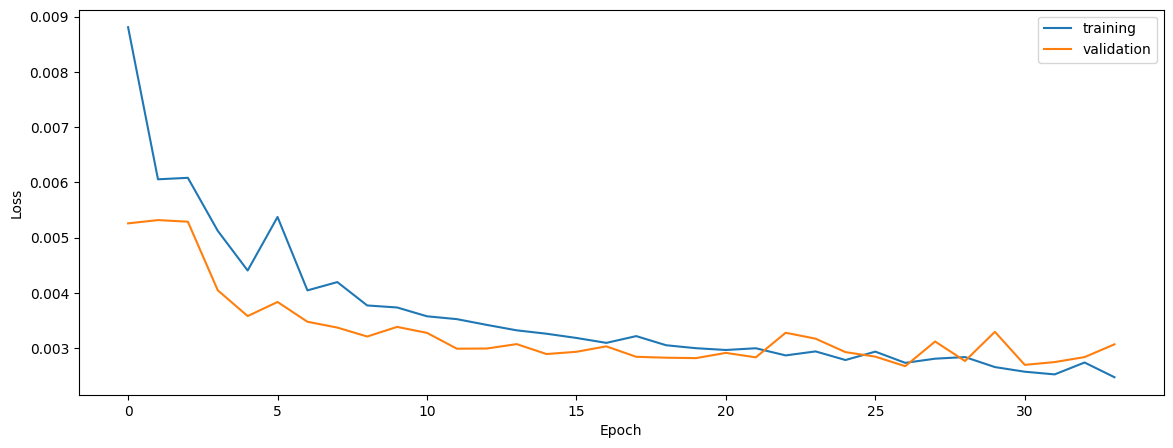

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8468546244690036
0.8314569170018586
0.8265995295990711


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8473431901599878
0.8455648816367894
0.8295023560009231


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8455448723950368
0.8434327118014551
0.8240426682248888


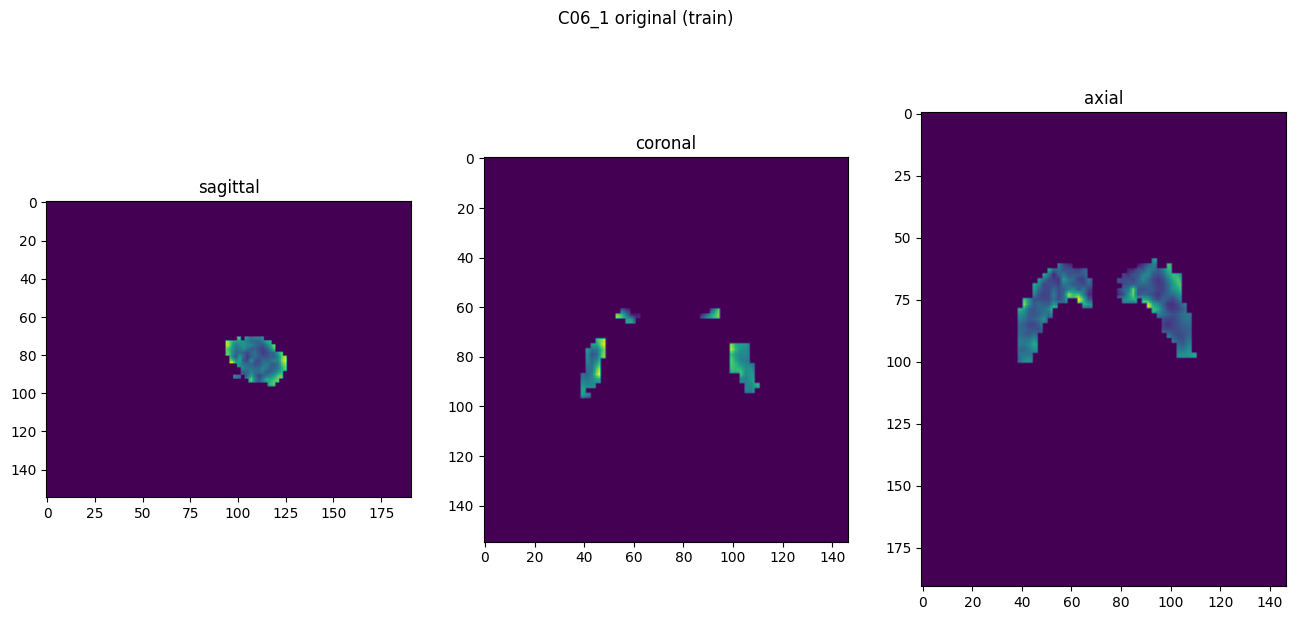

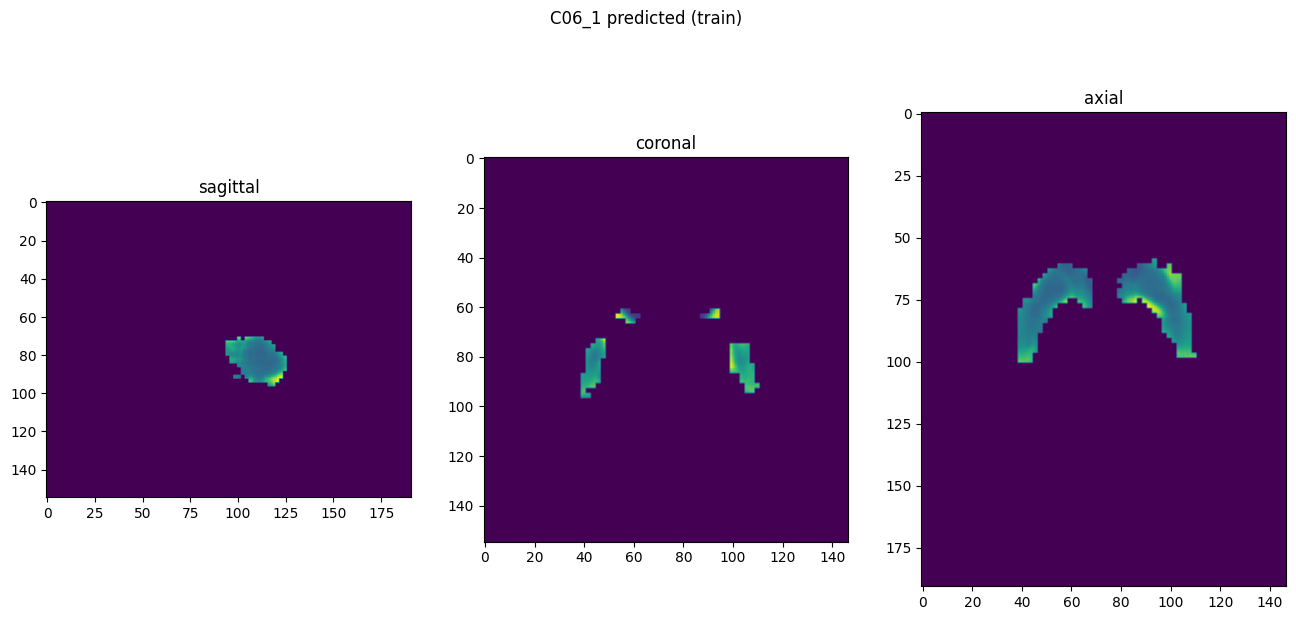

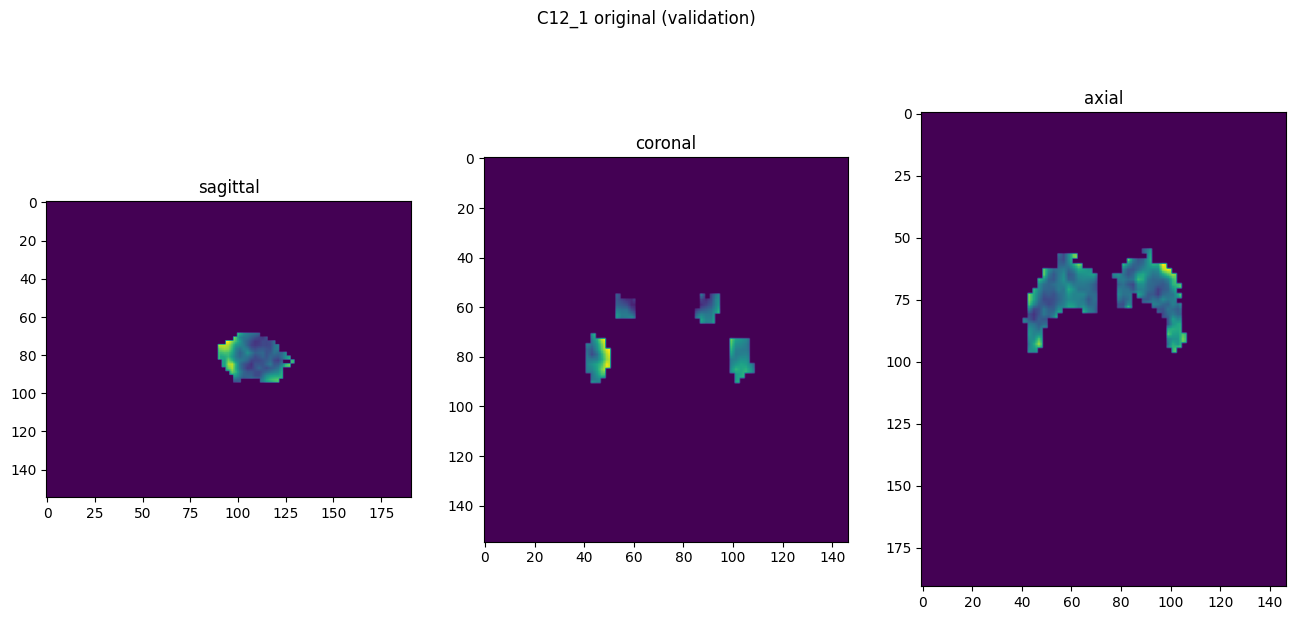

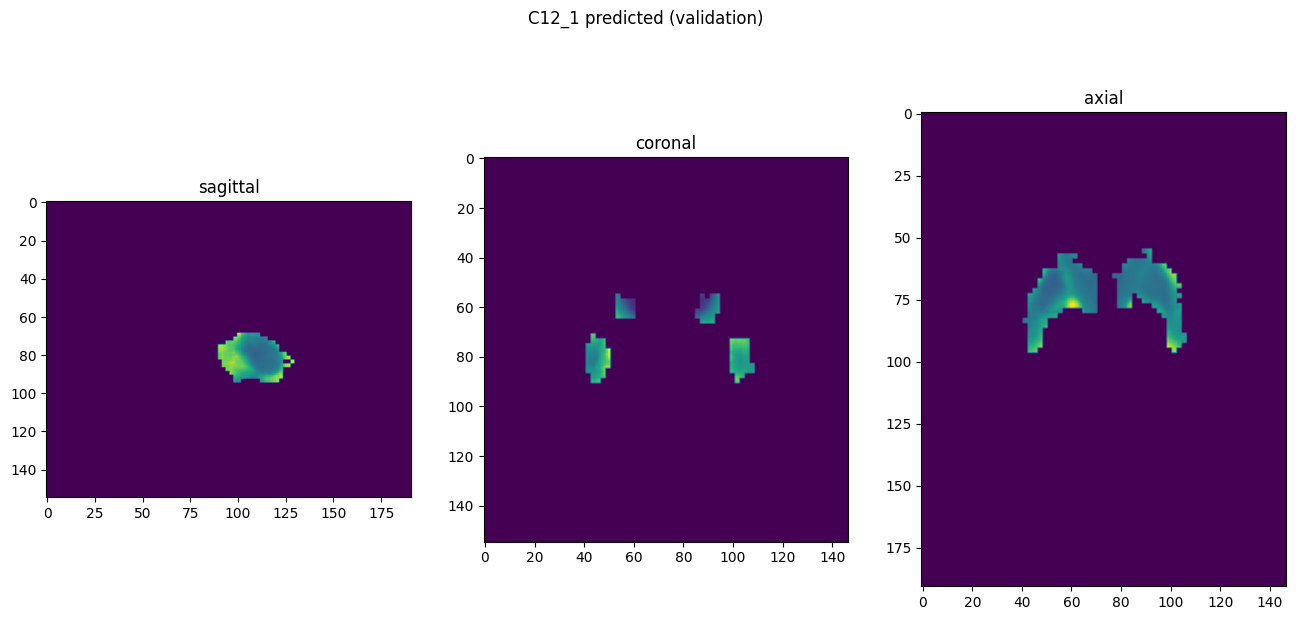

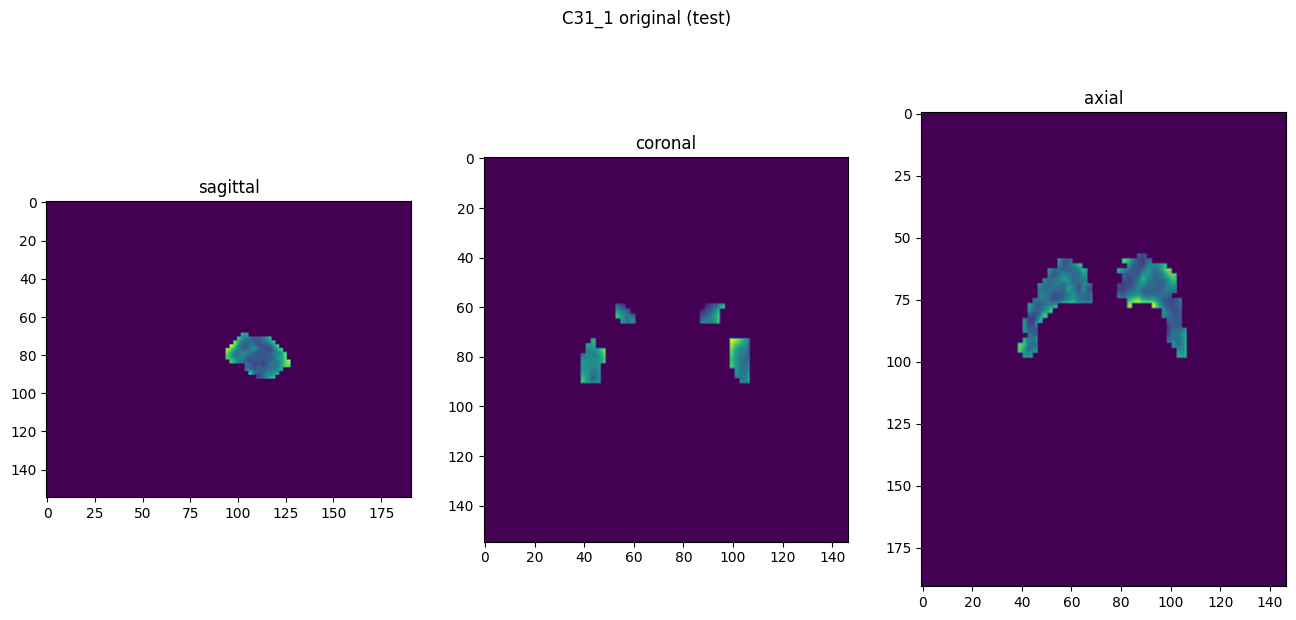

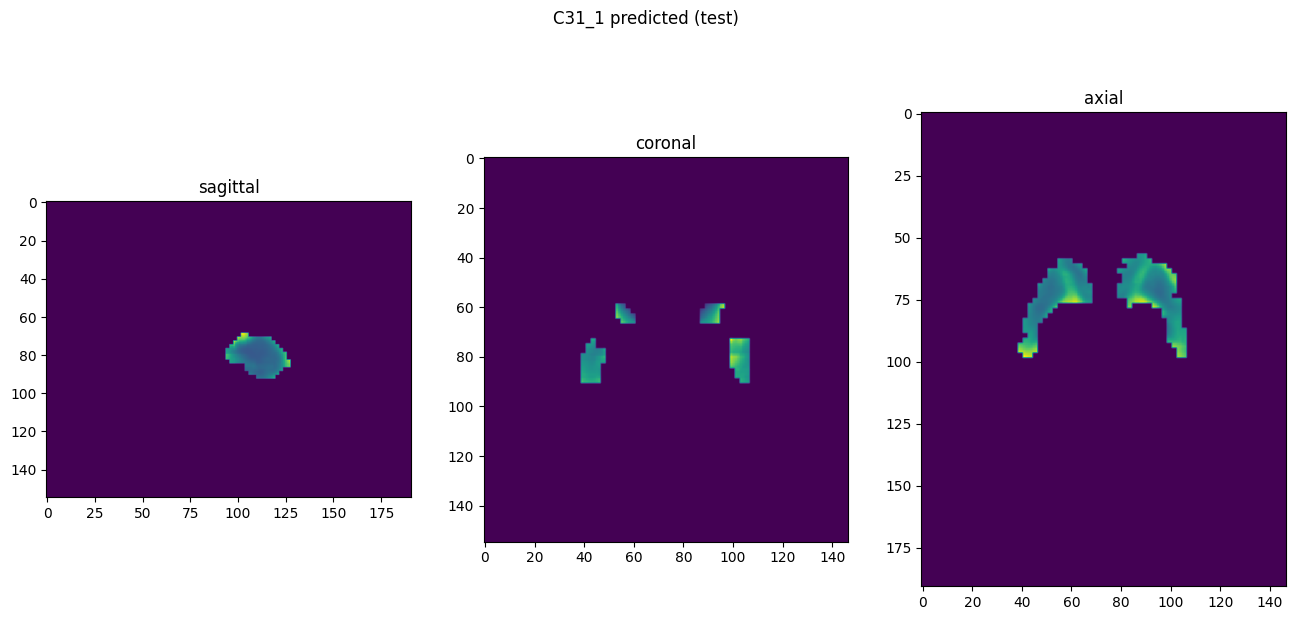

In [10]:
showResults(model, gen, threshold=None, background=False)